# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [25]:
!pip install catboost category_encoders xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.4 MB/s eta 0:00:00


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import category_encoders as ce

In [ ]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [ ]:
df.info()

In [ ]:
df.select_dtypes(include=['object', 'category'])

In [ ]:
df['company_location'].unique()

In [ ]:
expected_categories = {
    'experience_level': ['SE', 'MI', 'EN', 'EX'],
    'employment_type': ['FT', 'PT', 'CT', 'FL'],
    'company_size': ['S', 'M', 'L']
}

# проверка каждого признака
for feature, allowed in expected_categories.items():
    # проверка на пропуски
    if df[feature].isnull().any():
        print(f'Признак {feature} содержит пропущенные значения.')
    # проверка уникальных значений
    unique_values = df[feature].dropna().unique().tolist()
    invalid_values = [val for val in unique_values if val not in allowed]
    if invalid_values:
        print(f'Признак {feature} содержит недопустимые значения: {invalid_values}')
    else:
        print(f'Признак {feature}: все значения корректны.')

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [ ]:
df.duplicated().unique()

Имеются дубликаты. Удалим их.

In [ ]:
df.drop_duplicates(keep='first', inplace=True)

In [ ]:
df.isnull().sum()

Пропусков нет

In [ ]:
num_features = df.select_dtypes(include=['int', 'float']).columns

fig,ax = plt.subplots(figsize=(5,5))
ax.boxplot(x=df[num_features],
           vert=False,
           labels=num_features,
           sym='*'
          )
plt.title('Box plot for target')
plt.ylabel('Features')
plt.plot();

В признаке salary имеются сильные выбросы

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['salary'])
plt.title('Salary')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['salary_in_usd'])
plt.title('Salary in USD')


plt.show()

In [ ]:
mean_salary = df['salary_in_usd'].mean()
median_salary = df['salary_in_usd'].median()

print(f"Mean Salary in USD: {mean_salary}")
print(f"Median Salary in USD: {median_salary}")

In [ ]:
mean_salary = df['salary'].mean()
median_salary = df['salary'].median()

print(f"Mean Salary: {mean_salary}")
print(f"Median Salary: {median_salary}")

Зарплаты в долларе выглядят весьма реалистично и выбросы нельзя назвать аномальными выбросами, так как вполне возможно, что некоторые сотрудники компаний могут получать 300-500K долларов в год. Что касается признака salary, то большие значения здесь скорее связаны с тем, что выплаты происходят в слабой валюте с большими номинальными значениями.

In [ ]:
correlation_matrix = df[num_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

Сильной корреляции между признаками нет.

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [ ]:
# Вывод списка признаков
print("Список признаков:")
print(df.columns.tolist())

job_title является названием должности и не представляет для нас какой-то важности, удалим его.
Вероятно признак 'salary' тоже не очень важен для нас, поскольку мы имеем 'salary_in_usd', так как мы не сможем корректно сравнивать зарплаты в разных валютах и их всё равно нужно будет конвертировать в одну базовую валюту. Однако этот признак пока оставим

In [ ]:
cat_features = df.select_dtypes(include=['object', 'category']).columns

for feature in df[cat_features].columns.tolist():
  if len(df[feature].unique()) > 5:
    print(f"Признак {feature} имеет больше 5 категорий:\n", df[feature].unique(), '\n')

In [ ]:
df.drop('job_title', axis=1, inplace=True)

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [ ]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [ ]:
target = 'salary_in_usd'

# непрерывные
continuous_features = df.select_dtypes(include=['int64', 'float64']).columns.drop(target).tolist()

# непрерывные + категориальные
all_features = df.columns.drop(target).tolist()

# для первого сценария (только непрерывные признаки)
X_train_cont = df.loc[train.index, continuous_features]
X_test_cont = df.loc[test.index, continuous_features]
y_train_cont = df.loc[train.index, target]
y_test_cont = df.loc[test.index, target]

# для второго сценария (непрерывные + категориальные)
X_train_all = df.loc[train.index, all_features]
X_test_all = df.loc[test.index, all_features]
y_train_all = df.loc[train.index, target]
y_test_all = df.loc[test.index, target]

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

model = LinearRegression()
model.fit(X_train_cont, y_train_cont)

y_train_pred = model.predict(X_train_cont)
y_test_pred = model.predict(X_test_cont)

# MAPE и RMSE
def evaluate_model(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # в процентах
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mape, rmse

# оценка на тренировочной выборке
train_mape, train_rmse = evaluate_model(y_train_cont, y_train_pred)

# оценка на тестовой выборке
test_mape, test_rmse = evaluate_model(y_test_cont, y_test_pred)

print(f"Train MAPE: {train_mape:.2f}%, Train RMSE: {train_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%, Test RMSE: {test_rmse:.2f}")

Качество модели плохое, метрики слишком большие (чем меньше, тем лучше), переобучения нет, так как метрики на train и test близки по значениям.

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

model = CatBoostRegressor(
    loss_function='RMSE',
    random_state=42,
    verbose=0 # вывод логов
)

model.fit(X_train_cont, y_train_cont)

y_train_pred = model.predict(X_train_cont)
y_test_pred = model.predict(X_test_cont)

train_mape, train_rmse = evaluate_model(y_train_cont, y_train_pred)
test_mape, test_rmse = evaluate_model(y_test_cont, y_test_pred)

print(f"Train MAPE: {train_mape:.2f}%, Train RMSE: {train_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%, Test RMSE: {test_rmse:.2f}")

Метрики сильно улучшились на тренировочной выборке, однако мы видим сильную разницу в метриках относительно тестовой выборки, это означает, что catboost модель переобучилась на тестовой выборке.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [ ]:
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features

In [ ]:
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# 1. Кодирование категориальных признаков через One-Hot Encoding
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

X_train_all_encoded = ohe.fit_transform(X_train_all[cat_features])
X_test_all_encoded = ohe.transform(X_test_all[cat_features])

encoded_columns = ohe.get_feature_names_out(cat_features)

X_train_ohe = pd.concat([
    pd.DataFrame(X_train_all_encoded, columns=encoded_columns).reset_index(drop=True),
    X_train_all[continuous_features].reset_index(drop=True)
], axis=1)

X_test_ohe = pd.concat([
    pd.DataFrame(X_test_all_encoded, columns=encoded_columns).reset_index(drop=True),
    X_test_all[continuous_features].reset_index(drop=True)
], axis=1)

# Линейная регрессия
lr_ohe = LinearRegression()
lr_ohe.fit(X_train_ohe, y_train_all)
y_pred_lr_ohe = lr_ohe.predict(X_test_ohe)
mape_lr_ohe = mean_absolute_percentage_error(y_test_all, y_pred_lr_ohe) * 100
rmse_lr_ohe = np.sqrt(mean_squared_error(y_test_all, y_pred_lr_ohe))

# CatBoost (автоматически обрабатывает категориальные признаки)
model_ohe = CatBoostRegressor(cat_features=cat_features, verbose=0)
model_ohe.fit(X_train_all[cat_features + continuous_features], y_train_all)
y_pred_cat_ohe = model_ohe.predict(X_test_all[cat_features + continuous_features])
mape_cat_ohe = mean_absolute_percentage_error(y_test_all, y_pred_cat_ohe) * 100
rmse_cat_ohe = np.sqrt(mean_squared_error(y_test_all, y_pred_cat_ohe))

In [ ]:
# 2. Label Encoding
X_train_all_encoded = X_train_all.copy()
X_test_all_encoded = X_test_all.copy()

label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    X_train_all_encoded[col] = le.fit_transform(X_train_all_encoded[col])
    label_encoders[col] = le

    X_test_all_encoded[col] = X_test_all_encoded[col].apply(
        lambda x: x if x in le.classes_ else '<unknown>'
    )

    if '<unknown>' not in le.classes_:
        le.classes_ = np.append(le.classes_, '<unknown>')

    X_test_all_encoded[col] = le.transform(X_test_all_encoded[col])

# Линейная регрессия
lr_le = LinearRegression()
lr_le.fit(X_train_all_encoded[cat_features + continuous_features], y_train_all)
y_pred_lr_le = lr_le.predict(X_test_all_encoded[cat_features + continuous_features])
mape_lr_le = mean_absolute_percentage_error(y_test_all, y_pred_lr_le) * 100
rmse_lr_le = np.sqrt(mean_squared_error(y_test_all, y_pred_lr_le))

# CatBoost
model_le = CatBoostRegressor(verbose=0)
model_le.fit(X_train_all_encoded[cat_features + continuous_features], y_train_all)
y_pred_cat_le = model_le.predict(X_test_all_encoded[cat_features + continuous_features])
mape_cat_le = mean_absolute_percentage_error(y_test_all, y_pred_cat_le) * 100
rmse_cat_le = np.sqrt(mean_squared_error(y_test_all, y_pred_cat_le))

Для того, чтобы бороться с неизвестными классами в LabelEncoder использовал 1 подход из статьи: https://www.geeksforgeeks.org/sklearnlabelencoder-with-never-seen-before-values/#strategies-to-handle-unseen-values

In [ ]:
# 3. Mean Target Encoding

target_encoder = ce.TargetEncoder(
    handle_unknown="value", # заполняем неизвестные категории на среднее целевой переменной
    handle_missing="value" # заполняем пропуски на среднее целевой переменной
)
X_train_te = target_encoder.fit_transform(X_train_all[cat_features], y_train_all)
X_test_te = target_encoder.transform(X_test_all[cat_features])

X_train_te = pd.concat([X_train_te.reset_index(drop=True), X_train_all[continuous_features].reset_index(drop=True)], axis=1)
X_test_te = pd.concat([X_test_te.reset_index(drop=True), X_test_all[continuous_features].reset_index(drop=True)], axis=1)

# Линейная регрессия
lr_te = LinearRegression()
lr_te.fit(X_train_te, y_train_all)
y_pred_lr_te = lr_te.predict(X_test_te)
mape_lr_te = mean_absolute_percentage_error(y_test_all, y_pred_lr_te) * 100
rmse_lr_te = np.sqrt(mean_squared_error(y_test_all, y_pred_lr_te))

# # CatBoost
model_te = CatBoostRegressor(verbose=0)
model_te.fit(X_train_te, y_train_all)
y_pred_cat_te = model_te.predict(X_test_te)
mape_cat_te = mean_absolute_percentage_error(y_test_all, y_pred_cat_te) * 100
rmse_cat_te = np.sqrt(mean_squared_error(y_test_all, y_pred_cat_te))

In [ ]:
results = {
    "OHE": {
        "Linear Regression": {"MAPE": mape_lr_ohe, "RMSE": rmse_lr_ohe},
        "CatBoost": {"MAPE": mape_cat_ohe, "RMSE": rmse_cat_ohe}
    },
    "Label Encoding": {
        "Linear Regression": {"MAPE": mape_lr_le, "RMSE": rmse_lr_le},
        "CatBoost": {"MAPE": mape_cat_le, "RMSE": rmse_cat_le}
    },
    "Mean Target Encoding": {
        "Linear Regression": {"MAPE": mape_lr_te, "RMSE": rmse_lr_te},
        "CatBoost": {"MAPE": mape_cat_te, "RMSE": rmse_cat_te}
    }
}

print("Результаты:")
for encoding, models in results.items():
    print(f"\n=== {encoding} ===")
    for model, metrics in models.items():
        print(f"{model}: MAPE {metrics['MAPE']:.2f}%, RMSE {metrics['RMSE']:.2f}")

Во всех 3-х случаях можем увидеть, что модели линейной регрессии плохо справляются с задачей. В задании не сказано, что можно предобрабатывать признаки как-то ещё, кроме использования кодировщиков, однако чтобы попытаться улучшить метрики линейной регрессии можно масштабировать данные при помощи MinMaxScaler или StandardScaler, но CatBoost всё равно покажет наиболее хорошие результаты, поскольку это нелинейная модель.
Лучшие результаты показала модель CatBoost: MAPE 5.09% с LabelEncoder кодировщиком, дальше будем работать с ней.

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
test['experience_level'].unique()

In [ ]:
y_pred = model_le.predict(X_test_all_encoded[cat_features + continuous_features])

errors_df = pd.DataFrame({
    'y_true': y_test_all,
    'y_pred': y_pred,
    'absolute_error': abs(y_test_all - y_pred)
})

errors_df = pd.concat([test.sort_values(by='salary_in_usd').reset_index(drop=True), errors_df.sort_values(by='y_true').reset_index(drop=True)], axis=1)

# errors_df.sort_values(by='absolute_error', ascending=False).head(20)
top_errors = errors_df.nlargest(20, 'absolute_error')
top_errors

Исходя из таблицы с топ-20 ошибок нельзя сделать однозначных выводов. Видно, что модель переоценивает зарплаты интернов (experience_level = EN), завышая их реальные зарплаты, возможно делает такие выводы из-за страны, потому что все интерны в таблице ошибок из США или стран Евросоюза.


In [ ]:
# группировка по стране проживания
country_error = errors_df.groupby('employee_residence')['absolute_error'].mean().sort_values(ascending=False)
print("Средняя ошибка по странам:")
print(country_error.head())

# группировка по должности
job_error = errors_df.groupby('experience_level')['absolute_error'].mean().sort_values(ascending=False)
print("\nСредняя ошибка по должностям:")
print(job_error.head())

Посмотрим на наиболее важные признаки

In [ ]:
feature_columns = X_test_all_encoded[cat_features + continuous_features].columns
feature_importances = model_le.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='orange')
plt.xlabel('Важность признака')
plt.title('Важность признаков в модели')
plt.gca().invert_yaxis()  # Чтобы самый важный признак был сверху
plt.show()

Попробуем подробнее проинтерпретировать модель и посмотреть на вклад признаков в ответ, для этого используем SHAP метод:

In [ ]:
import shap

# вычисление SHAP-значений
explainer = shap.TreeExplainer(model_le)
shap_values = explainer.shap_values(X_test_all_encoded[cat_features + continuous_features])

shap.summary_plot(shap_values, X_test_all_encoded[cat_features + continuous_features], plot_type="bar")

Видно, что `salary` и `salary_currency` вносят наибольший вклад в ответ, что логично, если мы предсказываем зарплату в долларах и при этом даём модели значения зарплаты в местной валюте и саму валюту. Затем по важности идёт резиденство сотрудника и локация компании, где сотрудник работает, уже после этого модель смотрит на уровень экспертизы сотрудника.

In [ ]:
from bias_variance_decomp import bias_variance_decomp

_, avg_bias, avg_var = bias_variance_decomp(model_le, X_train_all_encoded[cat_features + continuous_features].values, y_train_all.values, X_test_all_encoded[cat_features + continuous_features].values, y_test_all.values,
                                            loss = 'mse', random_seed = 123)

In [ ]:
avg_bias

In [ ]:
avg_var

В результате видим, что среднее смещение (bias) намного выше средней дисперсии (variance), таким образом мы можем сделать вывод, что модель недообучена.
Можно попробовать использовать в качестве данных оригинальный датасет без предобработки при помощи LabelEcnoder, так как деревья умеют справляться с такой задачей. Также мы можем попробовать использовать ансамбли из дереьвьев, чтобы снизить дисперсию.

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model_le, X_train_all_encoded[cat_features + continuous_features], y_train_all, cv=5, scoring='neg_mean_squared_error'
)

plt.plot(train_sizes, -train_scores.mean(axis=1), label='Train MSE')
plt.plot(train_sizes, -test_scores.mean(axis=1), label='Test MSE')
plt.xlabel('Training examples')
plt.ylabel('MSE')
plt.legend()

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

Для начала попробуем обучить модель на исходных данных с ординальным кодированием некоторых признаков.

In [ ]:
X_train_all_01

In [ ]:
X_train_all_01 = X_train_all.copy()
X_test_all_01 = X_test_all.copy()

ordinal_features = ['experience_level', 'company_size'] # maybe: 'remote_ratio'
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
cat_features_without_ordinal_features = set(cat_features) - set(ordinal_features)

experience_order = {'EN': 0, 'MI': 1, 'SE': 2, 'EX': 3}
company_size_order = {'S': 0, 'M': 1, 'L': 2}

# вручную кодируем ординальные признаки
X_train_all_01['experience_level'] = X_train_all_01['experience_level'].astype(str).map(experience_order)
X_test_all_01['experience_level'] = X_test_all_01['experience_level'].astype(str).map(experience_order)
X_train_all_01['company_size'] = X_train_all_01['company_size'].astype(str).map(company_size_order)
X_test_all_01['company_size'] = X_test_all_01['company_size'].astype(str).map(company_size_order)

# для остальных используем LabelEncoder
label_encoders = {}
for col in cat_features_without_ordinal_features:
    le = LabelEncoder()
    X_train_all_01[col] = le.fit_transform(X_train_all_01[col])
    label_encoders[col] = le

    X_test_all_01[col] = X_test_all_01[col].apply(
        lambda x: x if x in le.classes_ else '<unknown>'
    )

    if '<unknown>' not in le.classes_:
        le.classes_ = np.append(le.classes_, '<unknown>')

    X_test_all_01[col] = le.transform(X_test_all_01[col])

# добавляем новые признаки
X_train_all_01["is_same_country"] = (X_train_all_01["employee_residence"] == X_train_all_01["company_location"]).astype(int)
X_test_all_01["is_same_country"] = (X_test_all_01["employee_residence"] == X_test_all_01["company_location"]).astype(int)

# список стран Евросоюза
EU_COUNTRIES = [
    "AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "ES", "FI",
    "FR", "GR", "HR", "HU", "IE", "IT", "LT", "LU", "LV", "MT",
    "NL", "PL", "PT", "RO", "SE", "SI", "SK"
]

# кодируем экономическое состояние страны компании (2 - США, 1 - ЕС, 0 - остальные)
def get_economic_status(country_code):
    if country_code == "US":
        return 2
    elif country_code in EU_COUNTRIES:
        return 1
    else:
        return 0
X_train_all_01["economic_status"] = X_train_all_01["company_location"].apply(get_economic_status)
X_test_all_01["economic_status"] = X_test_all_01["company_location"].apply(get_economic_status)

cb_01 = CatBoostRegressor(verbose=0)
cb_01.fit(X_train_all_01, y_train_all)
y_pred_cb_01 = cb_01.predict(X_test_all_01)
mape_cb_01 = mean_absolute_percentage_error(y_test_all, y_pred_cb_01) * 100
rmse_cb_01 = np.sqrt(mean_squared_error(y_test_all, y_pred_cb_01))

mape_cb_01, rmse_cb_01

In [ ]:
# вычисление SHAP-значений
explainer = shap.TreeExplainer(model_le)
shap_values = explainer.shap_values(X_test_all_01[cat_features + continuous_features])

shap.summary_plot(shap_values, X_test_all_01[cat_features + continuous_features], plot_type="bar")

В данном случае добавление признаков, добавленных исходя из логики, не улучшило метрики, а даже ухудшило их. Это, возможно, связано с тем, что на самом деле признаки salary и salary_currency фактически являются сильной подсказкой для модели и можно просто в принципе убрать остальные признаки, так как модели достаточно просто подогнать коэффициенты и выполнять роль конвертера валют. Попробуем наоборот избавиться от всех признаков, кроме 2 самых важных.

In [ ]:
X_train_all_02 = X_train_all.copy()
X_test_all_02 = X_test_all.copy()

X_train_all_02 = X_train_all_02[['salary', 'salary_currency']]
X_test_all_02 = X_test_all_02[['salary', 'salary_currency']]

# кодируем 'salary_currency'
le = LabelEncoder()
X_train_all_02['salary_currency'] = le.fit_transform(X_train_all_02['salary_currency'])
X_test_all_02['salary_currency'] = X_test_all_02['salary_currency'].apply(lambda x: x if x in le.classes_ else '<unknown>')
if '<unknown>' not in le.classes_:
    le.classes_ = np.append(le.classes_, '<unknown>')
X_test_all_02['salary_currency'] = le.transform(X_test_all_02['salary_currency'])

# обучаем модель
cb_02 = CatBoostRegressor(verbose=0)
cb_02.fit(X_train_all_02, y_train_all)
y_pred_cb_02 = cb_02.predict(X_test_all_01)
mape_cb_02 = mean_absolute_percentage_error(y_test_all, y_pred_cb_02) * 100
rmse_cb_02 = np.sqrt(mean_squared_error(y_test_all, y_pred_cb_02))

mape_cb_02, rmse_cb_02

Обучив модель всего на 2 признаках мы видим сильное улучшение по метрике MAPE и небольшое улучшение по метрике RMSE. Получается, что модели остальные признаки даже мешают, а не помогают прогнозировать целевое значение в данном конкретном случае.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time

cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# создание Pool объектов для CatBoost
train_pool = Pool(X_train_all, y_train_all, cat_features=cat_features)
test_pool = Pool(X_test_all, y_test_all, cat_features=cat_features)

model = CatBoostRegressor(
    loss_function='RMSE',
    verbose=100,
    random_seed=42,
    early_stopping_rounds=50
)

params_grid = {
    'depth': [6, 8],
    'learning_rate': [0.03, 0.1],
    'iterations': [800, 1000],
    'l2_leaf_reg': [1, 3]
}

# поиск по сетке
start_train = time.time()
grid_search = model.grid_search(
    params_grid,
    train_pool,
    cv=3,
    partition_random_seed=42,
    refit=True,
    shuffle=True,
    plot=False
)
train_time = time.time() - start_train

# замер времени
start_predict = time.time()
y_pred = model.predict(test_pool)
predict_time = time.time() - start_predict

print(f"\nTraining time: {train_time:.2f} sec")
print(f"Prediction time: {predict_time:.5f} sec")
print(f"MAE: {mean_absolute_error(y_test_all, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test_all, y_pred):.2f}")
print(f"R²: {r2_score(y_test_all, y_pred):.4f}")

print("\nBest parameters:")
print(grid_search['params'])

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train_all_03 = X_train_all.copy()
X_test_all_03 = X_test_all.copy()

# используем LabelEncoder
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train_all_03[col] = le.fit_transform(X_train_all_03[col])
    label_encoders[col] = le

    X_test_all_03[col] = X_test_all_03[col].apply(
        lambda x: x if x in le.classes_ else '<unknown>'
    )

    if '<unknown>' not in le.classes_:
        le.classes_ = np.append(le.classes_, '<unknown>')

    X_test_all_03[col] = le.transform(X_test_all_03[col])

X_train_all_03 = X_train_all_03.astype('float32')
X_test_all_03 = X_test_all_03.astype('float32')

# подбор гиперпараметров
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

model = XGBRegressor(objective='reg:squarederror', random_state=42)

# поиск по сетке
start_train = time.time()
search = RandomizedSearchCV(
    model,
    param_grid,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42
)
search.fit(X_train_all_03, y_train_all)
train_time = time.time() - start_train

best_model = search.best_estimator_

# прогнозирование
start_predict = time.time()
y_pred = best_model.predict(X_test_all_03)
predict_time = time.time() - start_predict

print(f"Training time: {train_time:.2f} sec")
print(f"Prediction time: {predict_time:.5f} sec")
print(f"MAE: {mean_absolute_error(y_test_all, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test_all, y_pred):.2f}")
print(f"R²: {r2_score(y_test_all, y_pred):.4f}")
print("\nBest parameters:", search.best_params_)

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
from lightgbm import LGBMRegressor

X_train_all_04 = X_train_all.copy()
X_test_all_04 = X_test_all.copy()

# используем LabelEncoder
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    X_train_all_04[col] = le.fit_transform(X_train_all_04[col])
    label_encoders[col] = le

    X_test_all_04[col] = X_test_all_04[col].apply(
        lambda x: x if x in le.classes_ else '<unknown>'
    )

    if '<unknown>' not in le.classes_:
        le.classes_ = np.append(le.classes_, '<unknown>')

    X_test_all_04[col] = le.transform(X_test_all_04[col])

X_train_all_04 = X_train_all_04.astype('float32')
X_test_all_04 = X_test_all_04.astype('float32')

param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'min_child_samples': [20, 50, 100]
}

model = LGBMRegressor(objective='regression', random_state=42, verbosity=-1)

# поиск гиперпараметров
start_train = time.time()
search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=15,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1
)
search.fit(X_train_all_04, y_train_all)
train_time = time.time() - start_train

best_model = search.best_estimator_

# прогнозирование
start_predict = time.time()
y_pred = best_model.predict(X_test_all_04)
predict_time = time.time() - start_predict

print(f"\nTraining time: {train_time:.2f} sec")
print(f"Prediction time: {predict_time:.5f} sec")
print(f"MAE: {mean_absolute_error(y_test_all, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test_all, y_pred):.2f}")
print(f"R²: {r2_score(y_test_all, y_pred):.4f}")
print("\nBest parameters:", search.best_params_)

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

Поскольку данные изначально имеют не линейную природу, то бустинги справляются лучше, потому что бустинг это нелинейное семейство моделей. Лучший результат из бустингов показал CatBoost с результатом R² = 0.9529, что является отличным результатом, XGBoost также показал схожий результат с метрикой R² = 0.9537. Различия между ними в том, что CatBoost умеет самостоятельно предобрабатывать и кодировать данные, поэтому при его использовании я не пользовался кодировщиком. Это также повлияло на время обучения модели, так CatBoost обучался 166 секунды, а XGBoost всего 44 секунды, что на целых 2 минуты быстрее. Самым быстрым оказался алгоритм LightGBM, который справился за 13 секунд, показав при этом результат чуть хуже остальных, но тоже очень хороший R² = 0.9377. Оптимальным можно считать результат, показанный XGBoost, так как он почти не теряет в качестве относительно CatBoost, но обучается существенно быстрее. В зависимости от ситуации все бустинги так или иначе подойдут для решения реальных задач.

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [4]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['dark_background'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

In [5]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [32]:
def load_data(file_path):
    """Загружает данные из файла."""
    return pd.read_csv(file_path, header=None, delim_whitespace=True) #, on_bad_lines='skip')

X_train = load_data('samsung_har/samsung_train.txt')
y_train = load_data('samsung_har/samsung_train.txt')
X_test = load_data('samsung_har/samsung_test.txt')
y_test = load_data('samsung_har/samsung_test.txt')
train_labels = load_data('samsung_har/samsung_train_labels.txt')
test_labels = load_data('samsung_har/samsung_test_labels.txt')

X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
labels = pd.concat([train_labels, test_labels], axis=0)

X = X.astype('float64')
y = y.astype('float64')

X_train.shape, X_test.shape, labels.shape, train_labels.shape, test_labels.shape, X.shape, y.shape

<ipython-input-32-a3735099c1cb>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, header=None, delim_whitespace=True) #, on_bad_lines='skip')
<ipython-input-32-a3735099c1cb>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, header=None, delim_whitespace=True) #, on_bad_lines='skip')
<ipython-input-32-a3735099c1cb>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read_csv(file_path, header=None, delim_whitespace=True) #, on_bad_lines='skip')
<ipython-input-32-a3735099c1cb>:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  return pd.read

((7352, 561),
 (2947, 561),
 (10299, 1),
 (7352, 1),
 (2947, 1),
 (10299, 561),
 (10299, 561))

In [7]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([-1.        , -0.99999999, -0.99999998, ...,  0.9999962 ,
        0.99999681,  1.        ])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [9]:
X_scaled

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
0,0.210534,-0.068703,-0.452195,-0.883335,-0.945431,-0.744387,-0.874687,-0.944877,-0.773250,-0.868773,...,-0.819093,-0.000264,-0.299902,-0.357898,0.062039,-0.782988,-0.019034,-0.674432,0.382008,-0.016151
1,0.060208,0.035902,-0.275222,-0.890098,-0.929817,-0.860322,-0.883627,-0.927796,-0.858859,-0.884263,...,0.127803,-0.925905,-0.789555,0.135993,-0.022538,-1.217721,1.470315,-0.681360,0.383148,-0.000121
2,0.078460,-0.046427,-0.085548,-0.883565,-0.913598,-0.906457,-0.878093,-0.904569,-0.908437,-0.876139,...,1.172610,-0.287824,-0.461181,-0.375145,0.391762,0.134732,1.686961,-0.689471,0.384289,0.019214
3,0.071375,-0.227794,-0.270741,-0.885188,-0.946015,-0.935521,-0.879495,-0.943980,-0.938095,-0.876139,...,1.132149,0.566244,0.436736,-0.132194,-0.034739,1.010013,-0.982261,-0.688915,0.388536,0.024624
4,0.033738,0.031617,-0.121380,-0.889855,-0.940846,-0.935041,-0.882451,-0.937622,-0.940948,-0.883152,...,-0.158720,-0.165153,-0.263958,0.343504,0.268015,1.096950,-1.251689,-0.687381,0.399066,0.038649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10294,0.529503,-0.960174,0.185107,0.729285,0.738886,0.985976,0.671427,0.778479,0.959693,1.210539,...,-0.212834,-0.242630,-0.431080,-1.025409,0.768198,1.407463,-1.422736,-0.303659,0.691994,0.889111
10295,1.316644,-0.578309,0.056759,0.689343,1.076214,1.032342,0.629191,1.023717,0.864009,1.210539,...,-0.101244,-0.068167,-0.267420,-2.211711,-0.839484,-1.095665,0.684415,-0.310406,0.688561,0.880288
10296,1.118216,1.288059,-0.129415,0.634062,0.935694,0.899035,0.594164,0.810529,0.671554,0.880306,...,-0.786194,0.561361,0.487469,-0.562328,0.192082,1.101957,0.768150,-0.310750,0.691509,0.875719
10297,-0.543493,0.975327,0.234320,0.648934,0.560590,1.004592,0.583607,0.508257,0.815788,0.880306,...,-0.705592,0.290917,-0.000118,1.297936,-1.837152,1.479507,0.001693,-0.319284,0.659762,0.899444


### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=561, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [11]:
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
prop_var

array([5.07382210e-01, 6.23918578e-02, 2.69256386e-02, 2.45287097e-02,
       1.88893566e-02, 1.63139540e-02, 1.41453324e-02, 1.21621062e-02,
       9.85247564e-03, 9.49228193e-03, 8.58303631e-03, 8.09979908e-03,
       7.65862670e-03, 6.76667617e-03, 6.30241618e-03, 6.15717733e-03,
       5.95334955e-03, 5.77195494e-03, 5.63431287e-03, 5.40829854e-03,
       5.18827870e-03, 5.02741666e-03, 4.73229478e-03, 4.63818462e-03,
       4.46848418e-03, 4.39868265e-03, 4.16863053e-03, 4.00808602e-03,
       3.89071892e-03, 3.81338573e-03, 3.66869737e-03, 3.64357439e-03,
       3.49224522e-03, 3.46736068e-03, 3.35538910e-03, 3.29410516e-03,
       3.23824350e-03, 3.00508156e-03, 2.94253973e-03, 2.90452465e-03,
       2.75764996e-03, 2.69864104e-03, 2.64195735e-03, 2.58030269e-03,
       2.55030824e-03, 2.47775822e-03, 2.45537494e-03, 2.38290353e-03,
       2.35901952e-03, 2.32043684e-03, 2.28360307e-03, 2.19181663e-03,
       2.12631367e-03, 2.09144562e-03, 2.03479658e-03, 2.01166715e-03,
      

In [12]:
eigenvalues

array([2.84669060e+02, 3.50052311e+01, 1.51067501e+01, 1.37619424e+01,
       1.05979581e+01, 9.15301694e+00, 7.93630205e+00, 6.82360410e+00,
       5.52777556e+00, 5.32568727e+00, 4.81555095e+00, 4.54442854e+00,
       4.29690679e+00, 3.79647396e+00, 3.53599881e+00, 3.45451190e+00,
       3.34015342e+00, 3.23838116e+00, 3.16115646e+00, 3.03435011e+00,
       2.91090699e+00, 2.82065462e+00, 2.65507517e+00, 2.60227424e+00,
       2.50706305e+00, 2.46790059e+00, 2.33882882e+00, 2.24875460e+00,
       2.18290527e+00, 2.13951714e+00, 2.05833908e+00, 2.04424372e+00,
       1.95933981e+00, 1.94537823e+00, 1.88255607e+00, 1.84817245e+00,
       1.81683101e+00, 1.68601446e+00, 1.65092509e+00, 1.62959655e+00,
       1.54719185e+00, 1.51408464e+00, 1.48228200e+00, 1.44769038e+00,
       1.43086185e+00, 1.39015734e+00, 1.37759910e+00, 1.33693869e+00,
       1.32353846e+00, 1.30189148e+00, 1.28122573e+00, 1.22972853e+00,
       1.19297780e+00, 1.17341493e+00, 1.14163173e+00, 1.12865486e+00,
      

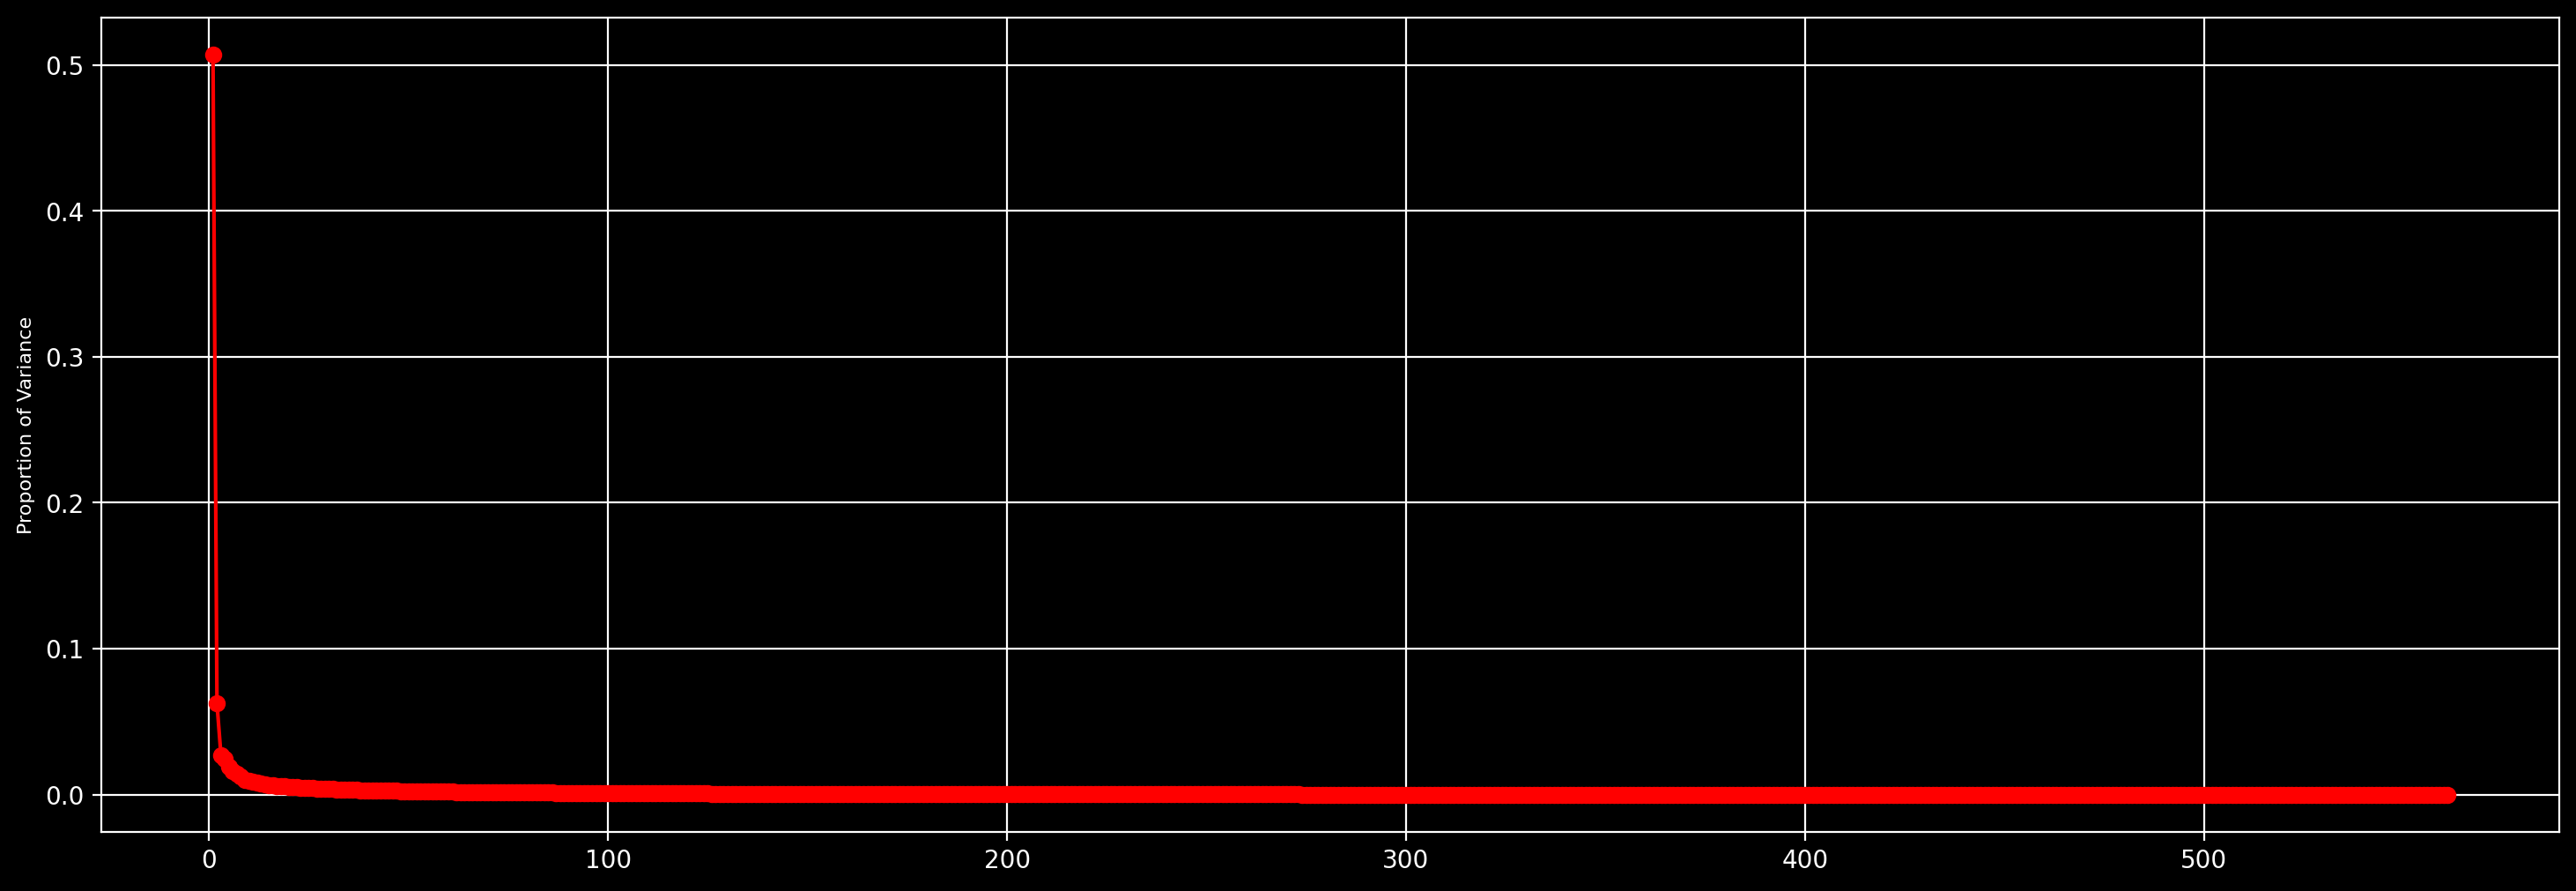

In [13]:
PC_numbers = np.arange(pca.n_components_) + 1

plt.plot(PC_numbers,
         prop_var,
         'ro-')
plt.ylabel('Proportion of Variance', fontsize=8)
plt.grid()
plt.gcf().set_size_inches(18, 6)
plt.show()

In [14]:
cumulative_var = np.cumsum(prop_var)

n_components_90 = np.argmax(cumulative_var >= 0.9) + 1  # +1 потому что индексы начинаются с 0
print(f"Количество компонент для 90% дисперсии: {n_components_90}")
print(f"Фактическая объясненная дисперсия с {n_components_90} компонентами: {cumulative_var[n_components_90-1]:.4f}")

Количество компонент для 90% дисперсии: 65
Фактическая объясненная дисперсия с 65 компонентами: 0.9005


In [15]:
pca = PCA(n_components=65, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

In [16]:
X_pca.shape

(10299, 65)

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

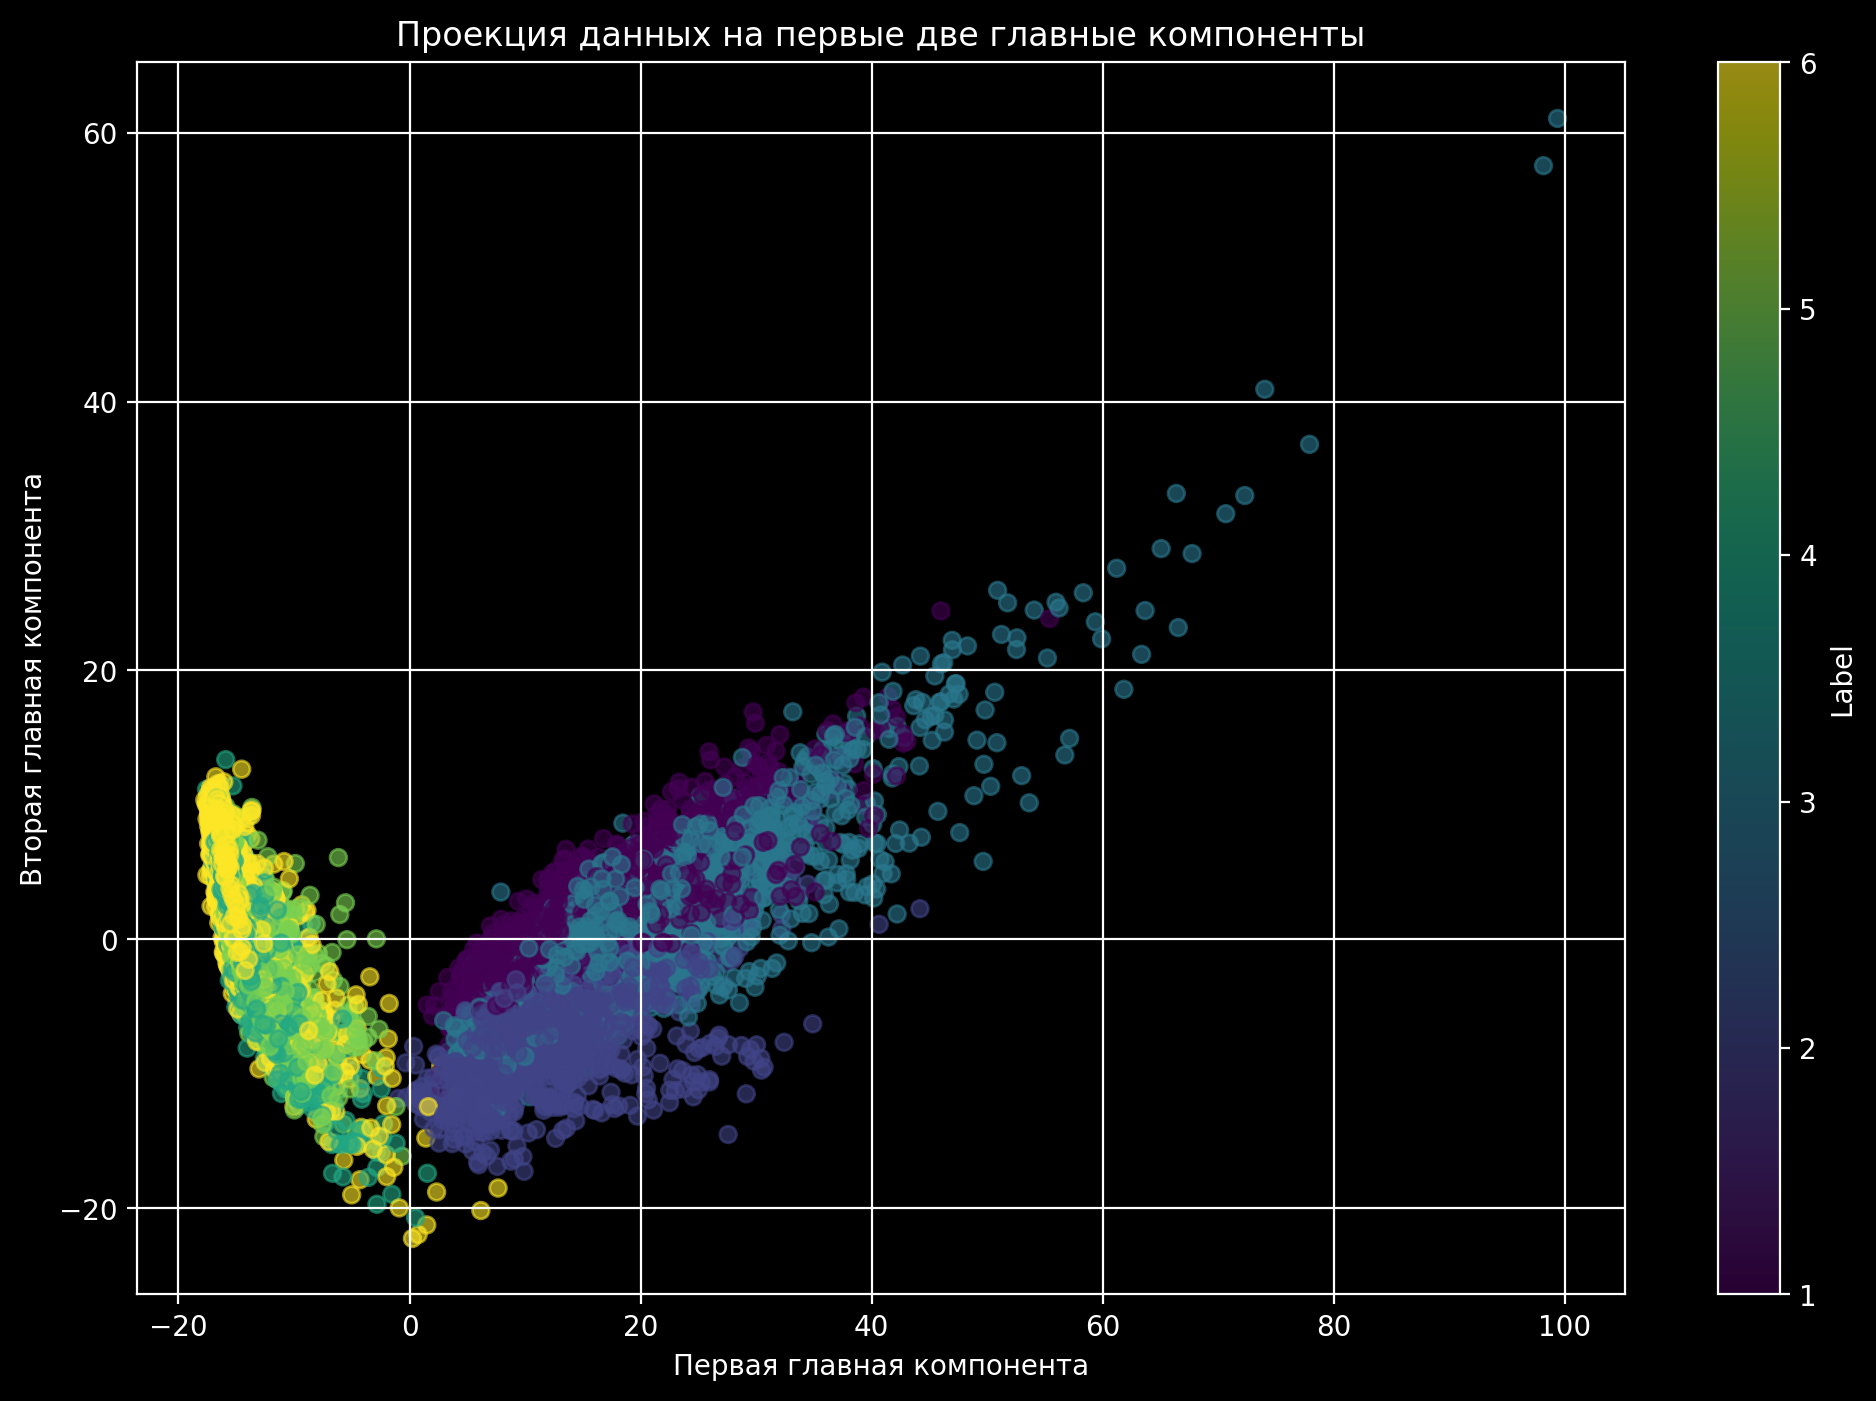

In [17]:
import matplotlib.pyplot as plt

# две компоненты из X_pca
pc1 = X_pca[:, 0]  # главная компонента 1
pc2 = X_pca[:, 1]  # главная компонента 2

# scatter plot с использованием labels для раскраски
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pc1, pc2, c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Label')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Проекция данных на первые две главные компоненты')
plt.grid(True)
plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [18]:
from sklearn.cluster import KMeans
import time

kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100)

# обучение
start_time_fit = time.time()
kmeans.fit(X_pca)
end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit

# инференс
start_time_predict = time.time()
cluster_labels = kmeans.predict(X_pca)
end_time_predict = time.time()
predict_time = end_time_predict - start_time_predict

# результаты
print(f"Время обучения KMeans: {fit_time:.4f} секунд")
print(f"Время инференса KMeans: {predict_time:.4f} секунд")
print(f"Размерность X_pca: {X_pca.shape}")
print(f"Первые 10 меток кластеров: {cluster_labels[:10]}")

Время обучения KMeans: 19.7556 секунд
Время инференса KMeans: 0.0067 секунд
Размерность X_pca: (10299, 65)
Первые 10 меток кластеров: [2 2 2 2 2 2 2 2 2 2]


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

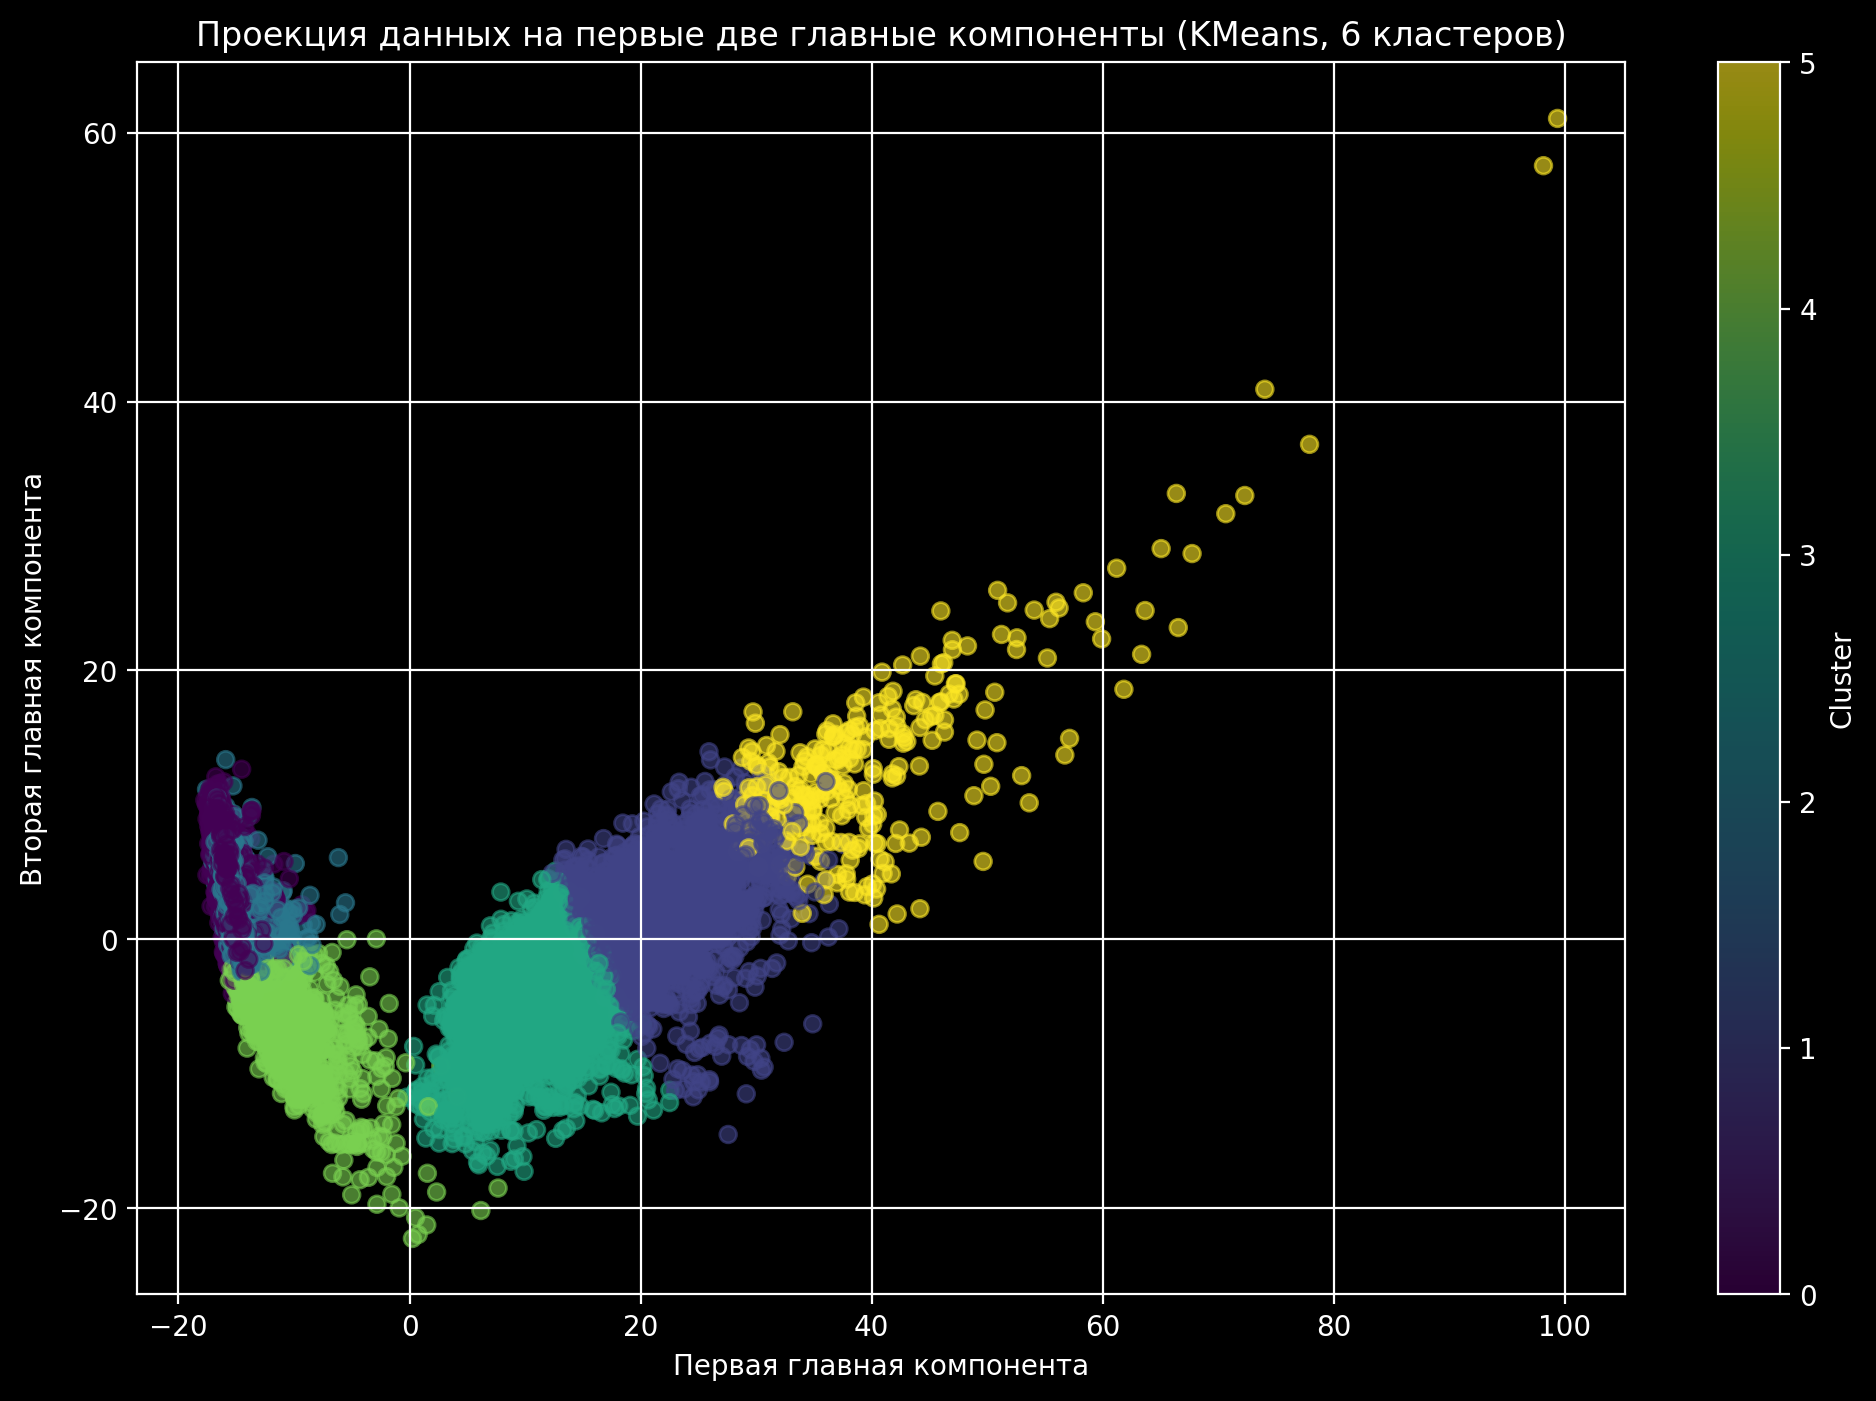

In [19]:
# две компоненты из X_pca
pc1 = X_pca[:, 0]  # главная компонента 1
pc2 = X_pca[:, 1]  # главная компонента 2

# scatter plot с использованием labels для раскраски
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pc1, pc2, c=cluster_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Проекция данных на первые две главные компоненты (KMeans, 6 кластеров)')
plt.grid(True)
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [59]:
# чтобы посчитать метрики, нужно использовать X_train и X_test (я не понял зачем их надо было объединить в 16 задании), поэтому проделаем ещё раз тоже самое но по отдельности для каждой выборки
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 1. Скалируем выборки
scaler = StandardScaler()
X_train_np = scaler.fit_transform(X_train)
X_test_np = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_np, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_np, columns=X_test.columns)

# 2. Уменьшим размерность выборок
pca = PCA(n_components=561, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_

cumulative_var = np.cumsum(prop_var)

n_components_90 = np.argmax(cumulative_var >= 0.9) + 1  # +1 потому что индексы начинаются с 0
print(f"Количество компонент для 90% дисперсии: {n_components_90}")
print(f"Фактическая объясненная дисперсия с {n_components_90} компонентами: {cumulative_var[n_components_90-1]:.4f}")

pca = PCA(n_components=63, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# 3. Кластеризуем выборки при помощи K-Means
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100)

# обучение
start_time_fit = time.time()
kmeans.fit(X_train_pca)
end_time_fit = time.time()
fit_time = end_time_fit - start_time_fit

# инференс
start_time_predict = time.time()
cluster_labels_train = kmeans.predict(X_train_pca)
cluster_labels_test = kmeans.predict(X_test_pca)
end_time_predict = time.time()
predict_time = end_time_predict - start_time_predict

# результаты
print(f"Время обучения KMeans: {fit_time:.4f} секунд")
print(f"Время инференса KMeans: {predict_time:.4f} секунд")
print(f"Размерность X_test_pca: {X_test_pca.shape}")
print(f"Первые 10 меток кластеров: {cluster_labels_test[:10]}")

# 4. Посчитаем метрики
# метрики для обучающей выборки
ari_train = adjusted_rand_score(train_labels.to_numpy().flatten(), cluster_labels_train)
nmi_train = normalized_mutual_info_score(train_labels.to_numpy().flatten(), cluster_labels_train)

# метрики для тестовой выборки
ari_test = adjusted_rand_score(test_labels.to_numpy().flatten(), cluster_labels_test)
nmi_test = normalized_mutual_info_score(test_labels.to_numpy().flatten(), cluster_labels_test)

# результаты
print("\nМетрики качества кластеризации:")
print(f"Adjusted Rand Index (train): {ari_train:.4f}")
print(f"Adjusted Rand Index (test): {ari_test:.4f}")
print(f"Normalized Mutual Information (train): {nmi_train:.4f}")
print(f"Normalized Mutual Information (test): {nmi_test:.4f}")

# 5. Вывод о метриках
print("\nВывод:")
if ari_test > 0.7 and nmi_test > 0.7:
    print("Кластеризация хорошо соответствует истинным классам (ARI и NMI > 0.7).")
elif ari_test > 0.5 and nmi_test > 0.5:
    print("Кластеризация умеренно соответствует истинным классам (ARI и NMI > 0.5).")
else:
    print("Кластеризация слабо соответствует истинным классам (ARI и NMI < 0.5).")

Количество компонент для 90% дисперсии: 63
Фактическая объясненная дисперсия с 63 компонентами: 0.9005
Время обучения KMeans: 11.2713 секунд
Время инференса KMeans: 0.0046 секунд
Размерность X_test_pca: (2947, 63)
Первые 10 меток кластеров: [3 4 4 4 4 4 4 4 4 4]

Метрики качества кластеризации:
Adjusted Rand Index (train): 0.4197
Adjusted Rand Index (test): 0.4370
Normalized Mutual Information (train): 0.5589
Normalized Mutual Information (test): 0.5866

Вывод:
Кластеризация слабо соответствует истинным классам (ARI и NMI < 0.5).


**Выводы:**
Лучше выбрать следующие 2 метрики:
- Adjusted Rand Index (ARI) - это внешняя метрика, она измеряет сходство между двумя разбиениями (предсказанными кластерами и истинными метками) учитывая случайное совпадение. Значения находятся в диапазоне от -1 до 1, где 1 — идеальное совпадение, 0 — случайное разбиение, отрицательные значения — непохожие разбиения.
- Normalized Mutual Information (NMI) - измеряет количество общей информации между предсказанными кластерами и истинными метками, нормализованное для учета размера данных. Значения находятся в диапазоне от 0 до 1, где 1 — идеальное соответствие, 0 — отсутствие взаимной информации. Хорошо подходит для задач, где важна интерпретируемость совпадения.

Исходя из полученных метрик можно сказать, что кластеризация слабо соответствует истинным классам (ARI и NMI < 0.5)



### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [61]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=6) # нам нужно 6 кластеров

start_time_ac_fit = time.time()
ac_labels_train = ac.fit_predict(X_train_pca)
end_time_ac_fit = time.time()
ac_fit_time = end_time_ac_fit - start_time_ac_fit

# agglomerative_labels = clustering.labels_

start_time_ac_predict = time.time()
ac_labels_test = ac.fit_predict(X_test_pca)
end_time_ac_predict = time.time()
ac_predict_time = end_time_ac_predict - start_time_ac_predict

print(f"Время обучения AgglomerativeClustering: {ac_fit_time:.4f} секунд")
print(f"Время инференса AgglomerativeClustering: {ac_predict_time:.4f} секунд")
print(f"Размерность X_test_pca: {X_test_pca.shape}")
print(f"Первые 10 меток кластеров (test): {ac_labels_test[:10]}")

Время обучения AgglomerativeClustering: 6.6052 секунд
Время инференса AgglomerativeClustering: 0.7633 секунд
Размерность X_test_pca: (2947, 63)
Первые 10 меток кластеров (test): [2 5 5 5 5 5 5 5 5 5]


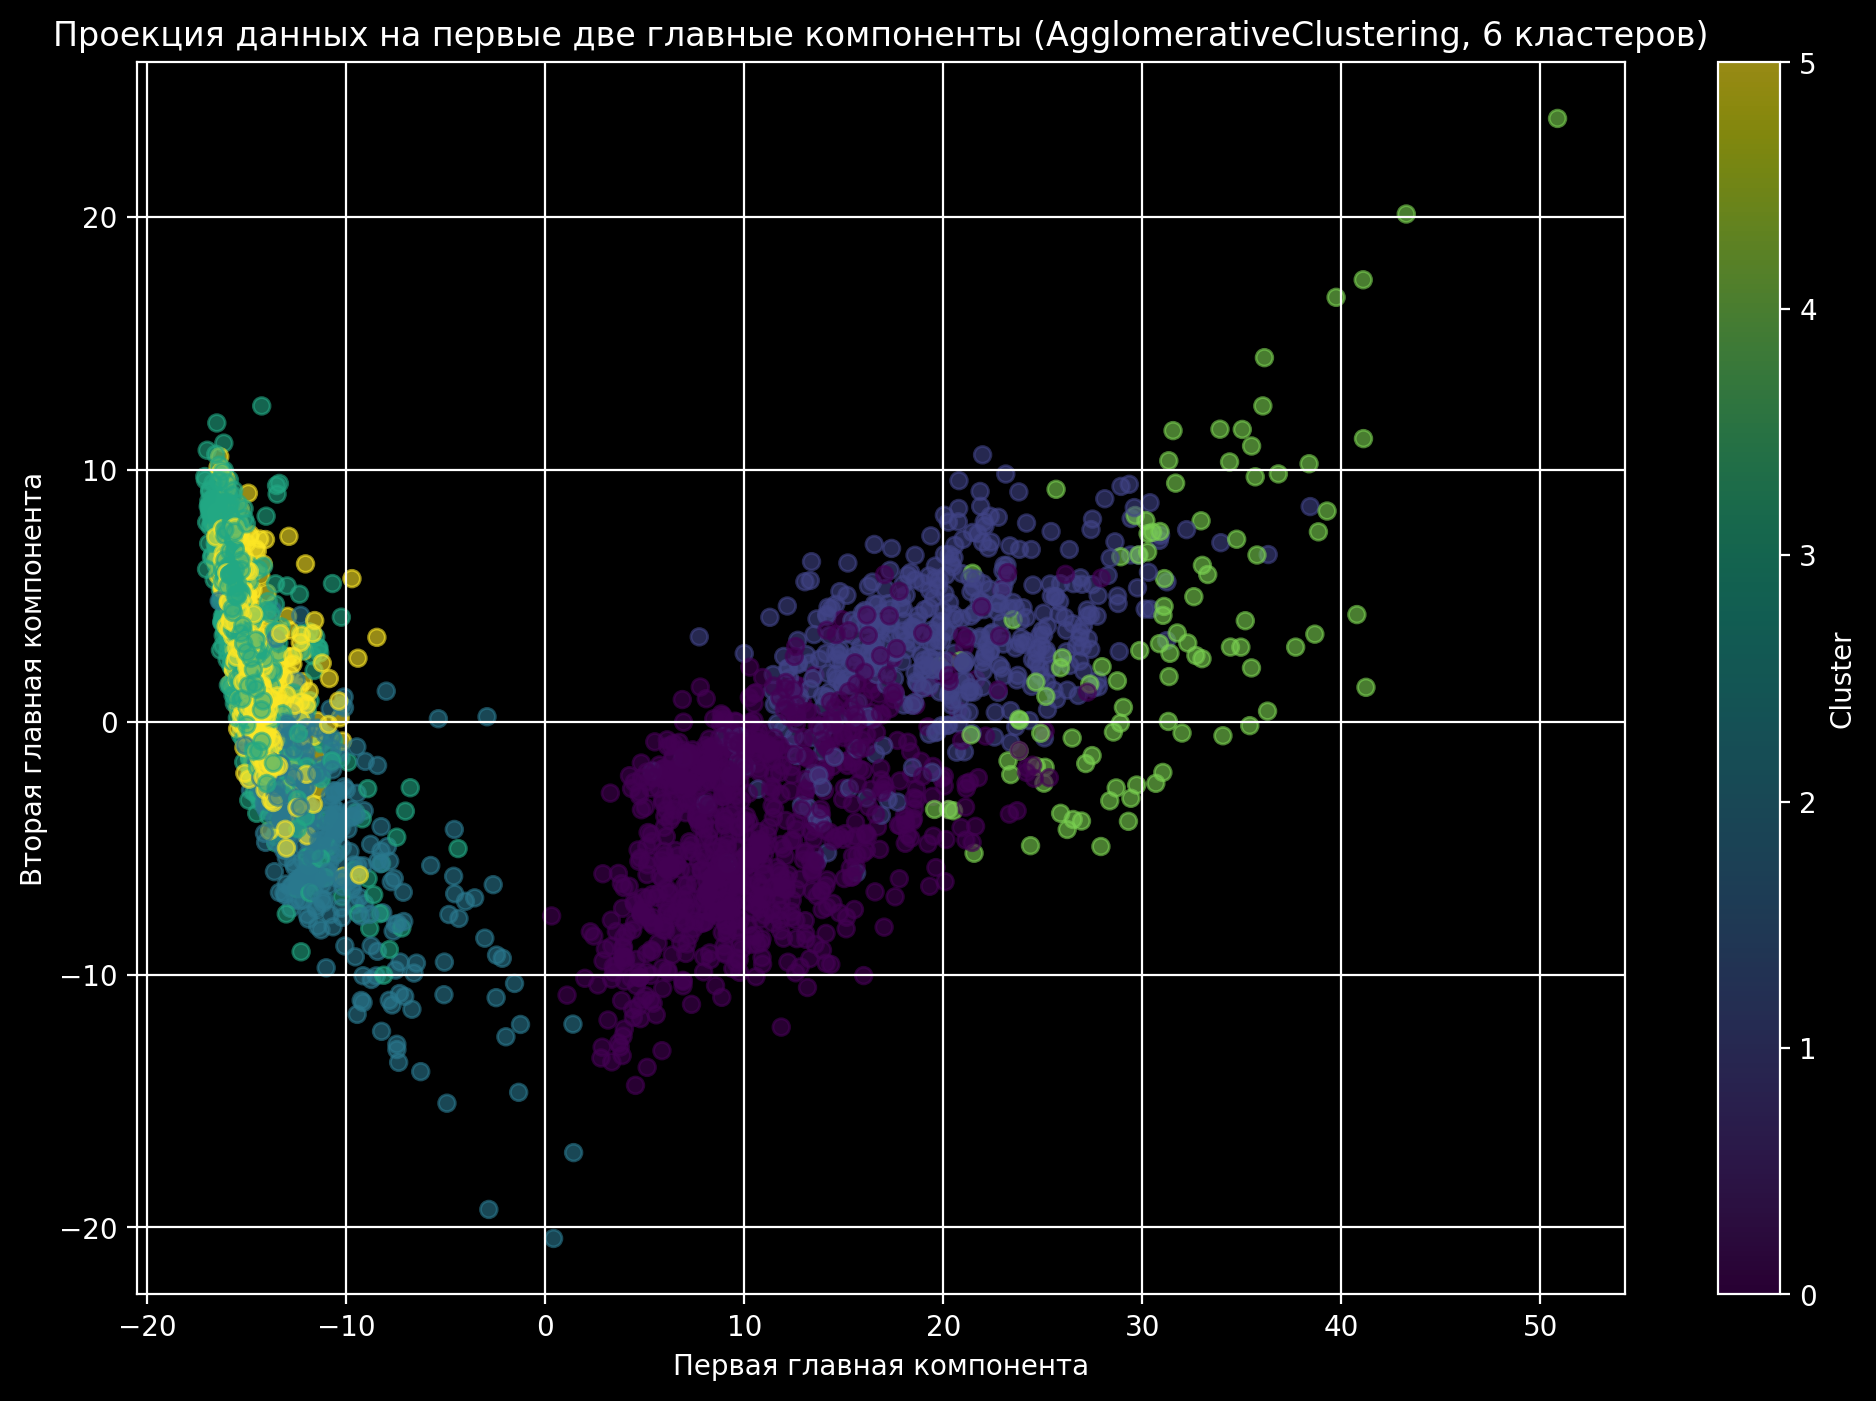

In [64]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=ac_labels_test, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Проекция данных на первые две главные компоненты (AgglomerativeClustering, 6 кластеров)')
plt.grid(True)
plt.show()

In [66]:
# посчитаем метрики для AgglomerativeClustering

# метрики для обучающей выборки
ari_agglo_train = adjusted_rand_score(train_labels.to_numpy().flatten(), ac_labels_train)
nmi_agglo_train = normalized_mutual_info_score(train_labels.to_numpy().flatten(), ac_labels_train)

# метрики для тестовой выборки
ari_agglo_test = adjusted_rand_score(test_labels.to_numpy().flatten(), ac_labels_test)
nmi_agglo_test = normalized_mutual_info_score(test_labels.to_numpy().flatten(), ac_labels_test)

# результаты метрик для AgglomerativeClustering
print("\nМетрики качества AgglomerativeClustering:")
print(f"Adjusted Rand Index (train): {ari_agglo_train:.4f}")
print(f"Adjusted Rand Index (test): {ari_agglo_test:.4f}")
print(f"Normalized Mutual Information (train): {nmi_agglo_train:.4f}")
print(f"Normalized Mutual Information (test): {nmi_agglo_test:.4f}")


Метрики качества AgglomerativeClustering:
Adjusted Rand Index (train): 0.4841
Adjusted Rand Index (test): 0.4774
Normalized Mutual Information (train): 0.6104
Normalized Mutual Information (test): 0.6256


**Выводы:**
Метрики при использовании кластеризации AgglomerativeClustering получились выше, чем при Kmeans. Чем ближе метрики к 1 - тем лучше. На графике видно, что Agglomerative кластеризация более детальная в сравнении с KMeans и разделяет кластеры по более сложным фигурам, которые к тому же пересекаются в нескольких местах. По временным затратам Agglomerative кластеризация также более быстрая

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

In [70]:
cluster_activity_df = pd.DataFrame({
    'Cluster': ac_labels_test,
    'True_Label': test_labels.to_numpy().flatten()
})

# распределение истинных меток по кластерам
cluster_distribution = pd.crosstab(cluster_activity_df['Cluster'], cluster_activity_df['True_Label'])
print("Распределение истинных меток по кластерам:")
print(cluster_distribution)

# интерпретация кластеров
activity_names = {
    1: "Ходьба",
    2: "Подъем по лестнице",
    3: "Спуск по лестнице",
    4: "Сидение",
    5: "Стояние",
    6: "Лежание"
}

print("\nИнтерпретация кластеров:")
for cluster in range(6):
    print(f"\nКластер {cluster}:")
    cluster_counts = cluster_distribution.loc[cluster]
    dominant_activity = cluster_counts.idxmax()
    dominant_count = cluster_counts.max()
    total_count = cluster_counts.sum()
    dominant_percentage = (dominant_count / total_count) * 100

    print(f"Доминирующая активность: {activity_names[dominant_activity]} ({dominant_count} из {total_count}, {dominant_percentage:.1f}%)")
    print("Распределение активностей в кластере:")
    for activity, count in cluster_counts.items():
        if count > 0:
            print(f" - {activity_names[activity]}: {count} ({(count/total_count)*100:.1f}%)")

Распределение истинных меток по кластерам:
True_Label    1    2    3    4    5    6
Cluster                                 
0           259  468  123    0    0    0
1           211    0  224    0    0    0
2             0    0    0  137  239   13
3             0    0    0    1    0  489
4            26    3   73    0    0    0
5             0    0    0  353  293   35

Интерпретация кластеров:

Кластер 0:
Доминирующая активность: Подъем по лестнице (468 из 850, 55.1%)
Распределение активностей в кластере:
 - Ходьба: 259 (30.5%)
 - Подъем по лестнице: 468 (55.1%)
 - Спуск по лестнице: 123 (14.5%)

Кластер 1:
Доминирующая активность: Спуск по лестнице (224 из 435, 51.5%)
Распределение активностей в кластере:
 - Ходьба: 211 (48.5%)
 - Спуск по лестнице: 224 (51.5%)

Кластер 2:
Доминирующая активность: Стояние (239 из 389, 61.4%)
Распределение активностей в кластере:
 - Сидение: 137 (35.2%)
 - Стояние: 239 (61.4%)
 - Лежание: 13 (3.3%)

Кластер 3:
Доминирующая активность: Лежание (489 из 4

**Выводы:**
1. Внутри каждого кластера объекты похожи на определённую деятельность человека. Больше всего совпадений при лежании (99,8%) и спуске по лестнице (71.6%). Судя по графику, который был отображён на реальных метках, в сравнении с графиком, который отрисован после применения AgglomerativeClustering, видно, что кластеры на реальных метках вытянуты вправо вверх, а на графике с AgglomerativeClustering они имеют более округлые формы.
2. Кластеры, в которых смешанно множество активностей:
  - Подъем по лестнице (468 из 850, 55.1%): в кластере остальные активности это спуск по лестнице, который по движениям очень похож на спуск, а также ходьба. Все движения динамичные, поэтому такая кластеризация имеет место быть, так как определить спускается человек по лестнице или поднимается может быть сложным.
  - Спуск по лестнице (224 из 435, 51.5%): аналогично подъёму по лестнице, в этот кластер попала ходьба, которая динимична по своей сути, однако не попал подъём.
  - Сидение (353 из 681, 51.8%): в этот кластер попало стояние, которое очень похоже по динамике на сидение, также есть немного лежания. По динамике движения похожи, поэтому могли попасть в общий кластер.
3. В целом, кластеризация получилась чуть выше среднего качества. Не могу назвать её хорошей глядя на графики, но если нам не очень важно, спускается человек по лестнице или поднимается, а нужно различать лишь факт того двигается ли человек или находится на одном месте, то такой кластеризации будет достаточно.

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

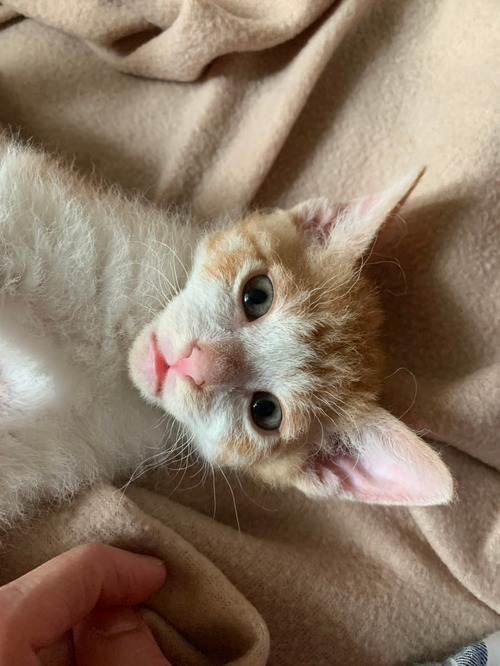

**Предположу, что этот замечательный кошак живёт у @malyushitsky**